<a href="https://colab.research.google.com/github/yurikelvin/pesquisa-icc/blob/main/An%C3%A1lise_Est%C3%A1tistica_ICC_Alunos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos dados obtidos do questionário aplicado aos discentes que pagaram a disciplina de "Introdução à Ciência da Computação" no período de 2018 a 2020.

In [ ]:
#@title Imports { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import re
import warnings
from tabulate import tabulate
import statistics
warnings.filterwarnings('ignore')

In [ ]:
# load data
df = pd.read_csv('icc_dados_alunos.csv')

In [ ]:
#@title Remoção de colunas que não serão usadas { display-mode: "form" }
wrapper = textwrap.TextWrapper(width=50)
df = df.drop(['Timestamp', 'Concorda que está suficientemente informado(a) a respeito da pesquisa que será realizada e concorda de livre e espontânea vontade em participar, como participante ?'], axis=1)
columnsUnsued = ['Qual o seu curso de graduação? (UFCG - Polo na Sede)', 'Alguma crítica que queira mencionar ao processo de aprendizagem desta disciplina? Forneça apenas comentários que motivem mudanças.', 'Você pode destacar algo que percebeu como positivo para o seu aprendizado durante o processo de aprendizagem na disciplina?']
dfColumnsUnsued = df[columnsUnsued]
df = df.drop(columnsUnsued, axis=1)

## Definição da escala de likert com seus respectivos labels:

Muito Insatisfeito 1

Mais ou menos insatisfeito 2

Nem satisfeito, nem insatisfeito 3

Mais ou menos satisfeito 4

Muito satisfeito 5

In [ ]:
likertMap = {
    "Muito insatisfeito": 1,
    "Mais ou menos insatisfeito": 2,
    "Nem satisfeito, nem insatisfeito": 3,
    "Mais ou menos satisfeito": 4,
    "Muito satisfeito": 5
}

## Preenchimento de valores que não foram preenchidos com o valor neutro da escala likert.

In [ ]:
df = df.fillna('Nem satisfeito, nem insatisfeito')

## Pré-processamento do dataframe

In [ ]:
#@title Renomear colunas
def processColumn(column):
  data = re.search(regex, str(column), re.IGNORECASE)
  if data:
    return data.group('question')
  return column

regex = "(?P<theme>.+)\s*\[(?P<question>.+)\]"
df = df.rename(columns=processColumn)
cols = [col for col in df.columns]

In [ ]:
#@title Definição do tamanho de cada grupo de perguntas do questionário utilizado
firstPartLength = 6
secondPartLength = 5
thirdPartLength = 4

## Processamento do dataframe para gerar um novo que seja mais fácil de manipular

In [ ]:
dfDict = {'question': []}
# number of people in interview
total = 163
for column in cols:
  dictRowValue = dict(df[column].value_counts())
  dfDict['question'].append(column)
  for key in likertMap:
    # get the percentage of response
    percentage = (dictRowValue[key] / total) * 100
    if key in dfDict:
      dfDict[key].append(percentage)
    else:
      dfDict[key] = [percentage]



In [ ]:
dfData = pd.DataFrame(dfDict)
dfData['neutral/2'] = dfData['Nem satisfeito, nem insatisfeito'].divide(2)

Separando os dataframes em grupos diferentes, pois cada grupo em questão está representado da seguinte forma:

Primeiro grupo: Aspectos relacionados à disciplina (6 questões)

Segundo grupo: Ação de ensino do professor (5 questões)

Terceiro grupo: Autoavaliação dos alunos (4 questões)

In [ ]:
dfFirstPartData = dfData.iloc[0:firstPartLength]
dfSecondPartData = dfData.iloc[firstPartLength:15-thirdPartLength]
dfThirdPartData = dfData.iloc[firstPartLength + secondPartLength:15]
dfFirstPartData = dfFirstPartData.sort_values(by=['Mais ou menos satisfeito', 'Muito satisfeito', 'neutral/2'])
dfSecondPartData = dfSecondPartData.sort_values(by=['Mais ou menos satisfeito', 'Muito satisfeito', 'neutral/2'])
dfThirdPartData = dfThirdPartData.sort_values(by=['Mais ou menos satisfeito', 'Muito satisfeito', 'neutral/2'])

In [ ]:
dfFirstPartData = dfFirstPartData.drop(['neutral/2'], axis=1)
dfSecondPartData = dfSecondPartData.drop(['neutral/2'], axis=1)
dfThirdPartData = dfThirdPartData.drop(['neutral/2'], axis=1)

## Gráficos

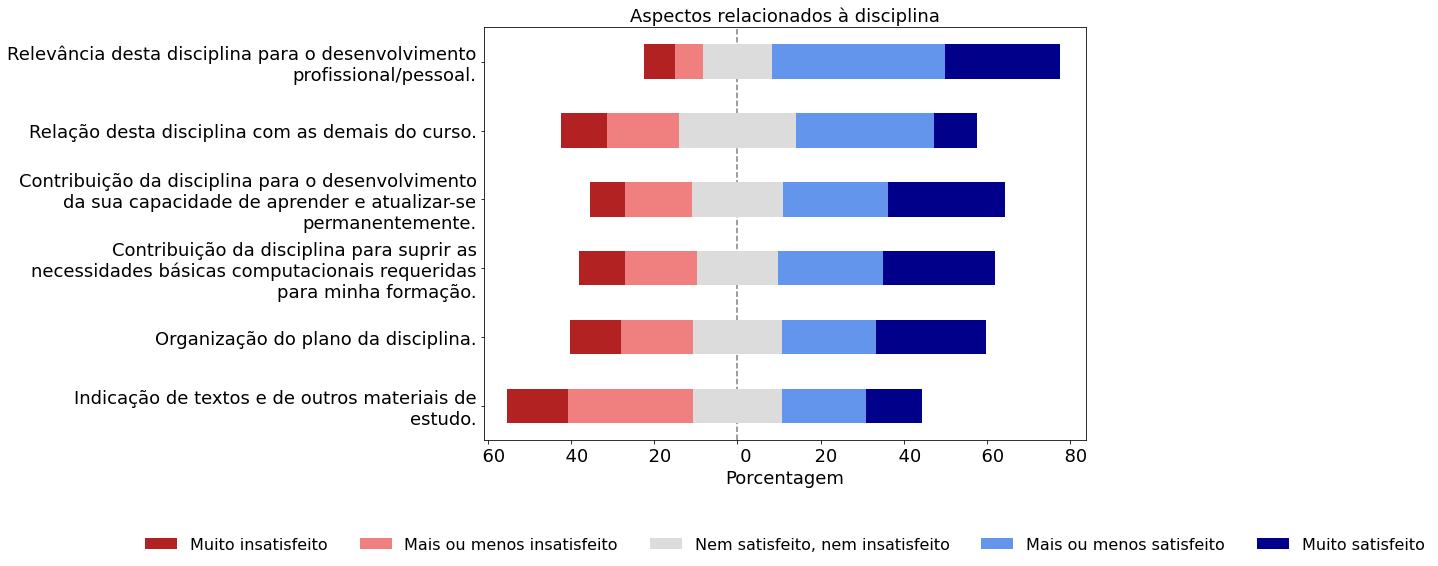

In [ ]:
#@title Visualização da Distribuição da "Aspectos relacionados à disciplina" { vertical-output: true, display-mode: "form" }
dfFirstPartData['question'] = dfFirstPartData['question'].apply(lambda x: wrapper.fill(x))
# set the questions as the index for easier plotting later on
# (alternatively one could explicitly state in the plotting call which column to use for labeling)
dfFirstPartData = dfFirstPartData.set_index('question')
# find out the middle value
# Note that this code is non-generic, and depends on the particular anchor points for the scale
middles = dfFirstPartData[["Muito insatisfeito", "Mais ou menos insatisfeito"]].sum(axis=1) + dfFirstPartData["Nem satisfeito, nem insatisfeito"]*.5

# define some margin (1.1) for the left hand side of the plot
longest = middles.max()*1.1

# insert the invisible column
dfFirstPartData.insert(0, '', (middles - longest).abs())

likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
# create the horizontal bar chart, using the subset 'all'
ax = dfFirstPartData.plot.barh(
    stacked=True, 
    color=likert_colors, 
    edgecolor='none',
    fontsize=18
)

# plot a vertical dashed line at 0
z = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
# put this line at the background
z.set_zorder(-1)

# define some margin (1.05) for the right hand side of the plot
complete_longest = int(dfFirstPartData.sum(axis=1).max()*1.05) 
plt.xlim(0, complete_longest)

# create custom tick positions and labels
# the value of 4000 is particularly chosen for this case
xvalues = [-60 + longest, -40 + longest, -20 + longest, 0 + longest, 20 + longest, 40 + longest, 60 + longest, 80 + longest]
xlabels = ['{:4.0f}'.format(abs(x - longest)) for x in xvalues]
plt.xticks(xvalues, xlabels)

# Shrink current axis's height by 10% on the bottom to make room for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width*1.8, box.height * 1.9])

# create the legend
handler, label = ax.get_legend_handles_labels()
ax.legend(
    handler, 
    label, 
    loc='upper center', 
    bbox_to_anchor=(.5, -0.2), 
    ncol=5, 
    edgecolor='white',
    fontsize=16
)

# set labels and title
plt.xlabel('Porcentagem', fontdict={'fontsize': 18})
plt.ylabel('')
plt.title('Aspectos relacionados à disciplina', fontdict={'fontsize': 18})

plt.show()

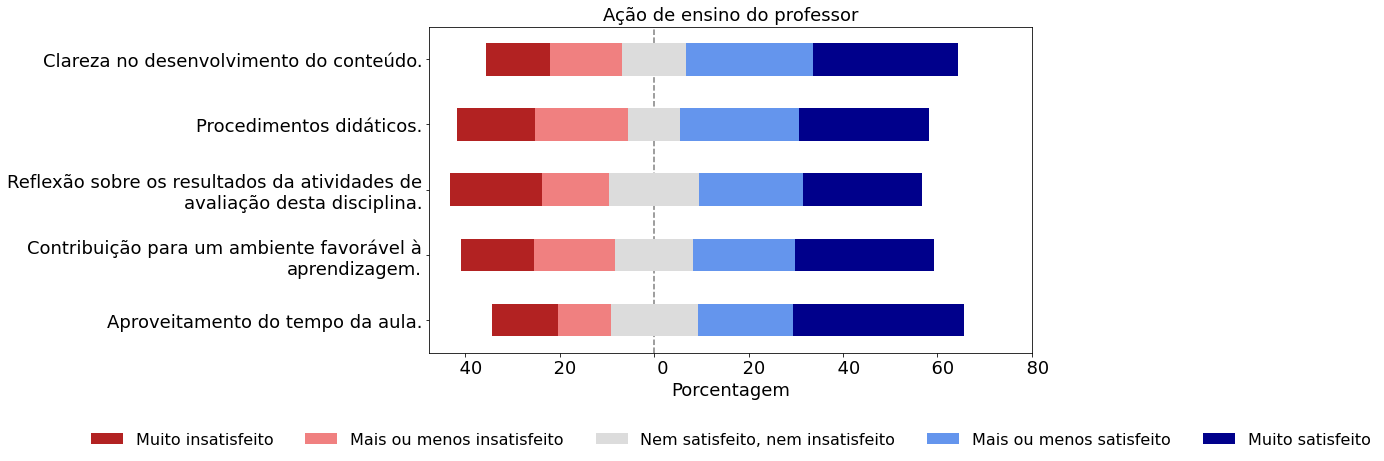

In [ ]:
#@title Visualização da Distribuição da "Ação de ensino do professor" { vertical-output: true, display-mode: "form" }
dfSecondPartData['question'] = dfSecondPartData['question'].apply(lambda x: wrapper.fill(x))
# set the questions as the index for easier plotting later on
# (alternatively one could explicitly state in the plotting call which column to use for labeling)
dfSecondPartData = dfSecondPartData.set_index('question')

# find out the middle value
# Note that this code is non-generic, and depends on the particular anchor points for the scale
middles = dfSecondPartData[["Muito insatisfeito", "Mais ou menos insatisfeito"]].sum(axis=1) + dfSecondPartData["Nem satisfeito, nem insatisfeito"]*.5

# define some margin (1.1) for the left hand side of the plot
longest = middles.max()*1.1

# insert the invisible column
dfSecondPartData.insert(0, '', (middles - longest).abs())

likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
# create the horizontal bar chart, using the subset 'all'
ax = dfSecondPartData.plot.barh(
    stacked=True, 
    color=likert_colors, 
    edgecolor='none',
    fontsize=18
)

# plot a vertical dashed line at 0
z = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
# put this line at the background
z.set_zorder(-1)

# define some margin (1.05) for the right hand side of the plot
complete_longest = int(dfSecondPartData.sum(axis=1).max()*1.05) 
plt.xlim(0, complete_longest)

# create custom tick positions and labels
# the value of 4000 is particularly chosen for this case
xvalues = [-40 + longest, -20 + longest, 0 + longest, 20 + longest, 40 + longest, 60 + longest, 80 + longest]
xlabels = ['{:4.0f}'.format(abs(x-longest)) for x in xvalues]
plt.xticks(xvalues, xlabels)

# Shrink current axis's height by 10% on the bottom to make room for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width*1.8, box.height * 1.5])

# create the legend
handler, label = ax.get_legend_handles_labels()
ax.legend(
    handler, 
    label, 
    loc='upper center', 
    bbox_to_anchor=(.5, -0.2), 
    ncol=5, 
    edgecolor='white',
    fontsize=16
)

# set labels and title
plt.xlabel('Porcentagem', fontdict={'fontsize': 18})
plt.ylabel('')
plt.title('Ação de ensino do professor', fontdict={'fontsize': 18})
plt.show()

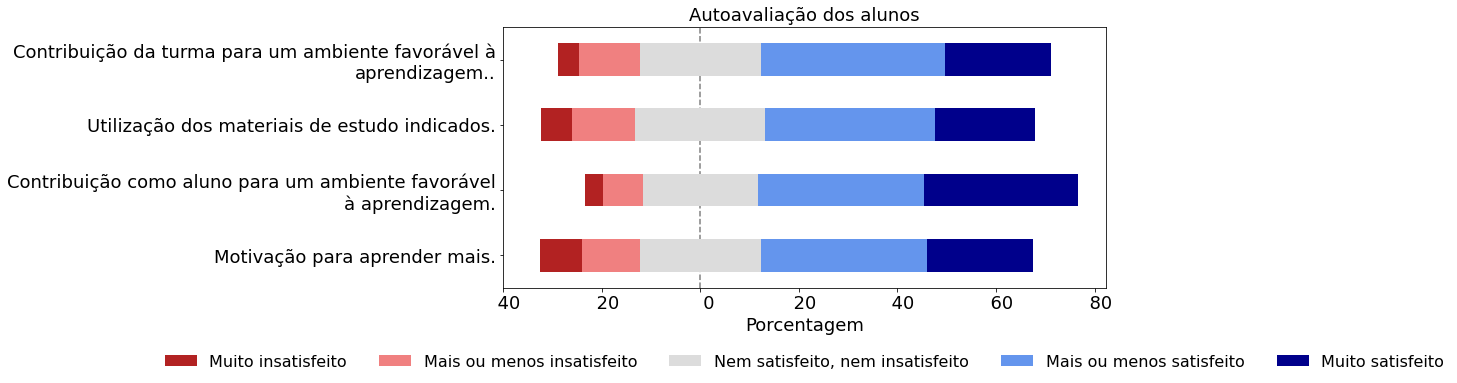

In [ ]:
#@title Visualização da Distribuição da "Autoavaliação dos alunos" { vertical-output: true, display-mode: "form" }
dfThirdPartData['question'] = dfThirdPartData['question'].apply(lambda x: wrapper.fill(x))
# set the questions as the index for easier plotting later on
# (alternatively one could explicitly state in the plotting call which column to use for labeling)
dfThirdPartData = dfThirdPartData.set_index('question')

# find out the middle value
# Note that this code is non-generic, and depends on the particular anchor points for the scale
middles = dfThirdPartData[["Muito insatisfeito", "Mais ou menos insatisfeito"]].sum(axis=1) + dfThirdPartData["Nem satisfeito, nem insatisfeito"]*.5

# define some margin (1.1) for the left hand side of the plot
longest = middles.max()*1.1

# insert the invisible column
dfThirdPartData.insert(0, '', (middles - longest).abs())

likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
# create the horizontal bar chart, using the subset 'all'
ax = dfThirdPartData.plot.barh(
    stacked=True, 
    color=likert_colors, 
    edgecolor='none',
    fontsize=18
)

# plot a vertical dashed line at 0
z = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
# put this line at the background
z.set_zorder(-1)

# define some margin (1.05) for the right hand side of the plot
complete_longest = int(dfThirdPartData.sum(axis=1).max()*1.05) 
plt.xlim(0, complete_longest)

# create custom tick positions and labels
# the value of 4000 is particularly chosen for this case
xvalues = [-40 + longest, -20 + longest, 0 + longest, 20 + longest, 40 + longest, 60 + longest, 80 + longest]
xlabels = ['{:4.0f}'.format(abs(x-longest)) for x in xvalues]
plt.xticks(xvalues, xlabels)

# Shrink current axis's height by 10% on the bottom to make room for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width*1.8, box.height * 1.2])

# create the legend
handler, label = ax.get_legend_handles_labels()
ax.legend(
    handler, 
    label, 
    loc='upper center', 
    bbox_to_anchor=(.5, -0.2), 
    ncol=5, 
    edgecolor='white',
    fontsize=16
)

# set labels and title
plt.xlabel('Porcentagem', fontdict={'fontsize': 18})
plt.ylabel('')
plt.title('Autoavaliação dos alunos', fontdict={'fontsize': 18})
plt.show()

## Explorando algumas estatísticas dos dados

In [ ]:
def transformLikertTextToNumber(text):
  if (type(text) == int): return text
  return likertMap[text]

Manipulando o dataframe para obter quantidade de respostas para cada afirmação colocada.

In [ ]:
statics = {'question': []}
for column in cols:
  dictRowValue = dict(df[column].value_counts())
  statics['question'].append(column)
  for key in likertMap:
    # get the percentage of response
    value = dictRowValue[key]
    if key in statics:
      statics[key].append(value)
    else:
      statics[key] = [value]

dfDataStatics = pd.DataFrame(statics)

Extração da mediana baseada nos valores respondidos em cada afirmação.

In [ ]:
mostRespondentsBelieve = {'Questão': [], 'Satisfação da maioria': []}
participantsTotal = 163
for i, row in dfDataStatics.iterrows():
  rowList = list(row)
  question = rowList[0]
  likert1 = rowList[1] * [1]
  likert2 = rowList[2] * [2]
  likert3 = rowList[3] * [3]
  likert4 = rowList[4] * [4]
  likert5 = rowList[5] * [5]
  responses = likert1 + likert2 + likert3 + likert4 + likert5
  median = statistics.median(responses)
  mostRespondentsBelieve['Questão'].append(question)
  if (median == 3):
    participantsWithOpinion = participantsTotal - rowList[3]
    disagreement = rowList[1]+rowList[2]
    agreement = rowList[4] + rowList[5]
    disagreementPercent = (disagreement/participantsTotal) * 100
    agreementPercent = (agreement/participantsTotal) * 100
    mostRespondentsBelieve['Satisfação da maioria'].append('{:.0f}% menos insatisfeito {:.0f}% mais satisfeito'.format(disagreementPercent, agreementPercent))
  else:
    mostRespondentsBelieve['Satisfação da maioria'].append(list(likertMap.keys())[list(likertMap.values()).index(median)])

### Mediana das questões

Obs: Se os dados apontarem o "Nem insatisfeito, nem satisfeito", é calculado a porcentagem de pessoas que estão menos insatisfeitas e as que estão mais satisfeitas.

In [ ]:
print(tabulate(mostRespondentsBelieve , headers='keys', tablefmt='f0ancy_grid'))

Questão                                                                                                          Satisfação da maioria
---------------------------------------------------------------------------------------------------------------  ------------------------------------------
Relevância desta disciplina para o desenvolvimento profissional/pessoal.                                         Mais ou menos satisfeito
Relação desta disciplina com as demais do curso.                                                                 28% menos insatisfeito 44% mais satisfeito
Organização do plano da disciplina.                                                                              29% menos insatisfeito 49% mais satisfeito
Indicação de textos e de outros materiais de estudo.                                                             45% menos insatisfeito 34% mais satisfeito
Contribuição da disciplina para o desenvolvimento da sua capacidade de aprender e atualizar-se permanen